In [1]:
%load_ext jupyternotify

import numpy as np
import matplotlib
#allow for latex markup in matplotlib figures
matplotlib.rcParams['text.usetex'] = False
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap


#Import a few utility functions...
import sys  
from pathlib import Path
sys.path.insert(0, "../comm_channel")
sys.path.insert(0, "../polling_systems")
sys.path.insert(0, "../geometry")
sys.path.insert(0, "../utils")

#So we can import my local libs
import CommChannel as CC
import qos
import pointcloud as PC
import TSPN
import PollingSystem as PS
import MarkovianRP as MRP
import dtr
import motion
import shot_solvers as SHOT

import sim_template as sim
from importlib import reload 

<IPython.core.display.Javascript object>

In [2]:
#setup quality of service requirements using reasonable values
F5GHz, F2_4GHz = 5, 2.4 #typical wifi frequencies are 2.4, 5, and sometiems 6 GHz
MOBILE_TX_POWER = qos.Pwr(20)#100-200mW (20-23 dBm) pretty typical, with 1W (30dBm) the absolute maximum
print(MOBILE_TX_POWER)
r = 8#any of 2, 4, 6, or 8
rx_noise = qos.Pwr(-85)#based on Yan and MostofiTWC13 #1e-10#
print(rx_noise)
BER = 1e-6
GAMMA_TH = qos.QoSReq(BER, r, rx_noise).thresholdChannelGain(MOBILE_TX_POWER)
print(GAMMA_TH)
print('SNR Threshold: %d'%(GAMMA_TH+MOBILE_TX_POWER.dBm - rx_noise.dBm))

20.000000 dBm	-10.000000 dBW	100.000000 mW	0.100000 W
-85.000000 dBm	-115.000000 dBW	0.000000 mW	0.000000 W
-71.8297512825111
SNR Threshold: 33


In [16]:
#Setup the communication environment:

#For now, use same channel params
nPL = 5.2
kPL = -20

decorrSH = 2.09  
alpha = 16
sigmaSH = np.sqrt(alpha)
psdAtFC = 30

lam = 0.125
kRic = 10
decorrMP = 0.4*lam         
corrMP = 1
#sigmaMP = 3
sigmaMP = 1.5


#12 remote stations
l = 11
qBase = np.array([[2,6],[21,4],
                 [16,11],[28,23],
                 [10,22],[11,39],
                 [30, 11],[48, 8],
                 [18, 36],[35, 41],
                 [32, 33],[48, 25],
                 [2,43],[18, 49]])#,
#                  [38,36],[48, 48]])

sub_regions = [[25,0,10,0],
               [30,10, 25, 9],
               [20,0, 40, 17],
               [50, 25, 15, 3],
               [38, 15, 45, 27],
               [50, 30, 40, 20],
               [17,0, 50, 38]]#,
#                [50, 34, 50, 35]]


x_max = 50
x_min = 0
y_max = 50
y_min = 0
region = [x_max, x_min, y_max, y_min]


cps = [CC.ChannelParams(qBase[i], nPL, kPL, sigmaSH, decorrSH, decorrMP, lam,
                      kRic, corrMP, psdAtFC, sigmaMP) for i in range(len(qBase))]



#res = 2/decorrMP
res = 10
n = 7
p_th = 0.5

#Polling System Setup
bandwidth = 2#leave bandwidth in MHz*1000000#give ourselfes 2MHz of BW
beta = 1/(r*bandwidth)
print(beta)
els = [0.01/beta, 0.1/beta, 0.1/beta, 0.01/beta, 0.1/beta, 0.01/beta, 0.01/beta]#, 0.05/beta]
print('Traffic: %.2f'%(sum(els)*beta))
print(els)

0.0625
Traffic: 0.34
[0.16, 1.6, 1.6, 0.16, 1.6, 0.16, 0.16]


In [4]:
reload(sim)
ccs, cfs, true_joint_con_fields, tjcps = sim.create_channels(cps, region, res, GAMMA_TH, sub_regions)

Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing genera

In [5]:
reload(sim)
pcs, pfs, pjcps, prob_pred_con = sim.predict_channels(res, ccs, true_joint_con_fields, GAMMA_TH, p_th=p_th)
trismall_pcs = pcs

print(prob_pred_con)

Drawing 250 samples from Channel 1
Completed PredictedChannel 1
Drawing 250 samples from Channel 2
Completed PredictedChannel 2
Drawing 320 samples from Channel 3
Completed PredictedChannel 3
Drawing 320 samples from Channel 4
Completed PredictedChannel 4
Drawing 460 samples from Channel 5
Completed PredictedChannel 5
Drawing 460 samples from Channel 6
Completed PredictedChannel 6
Drawing 300 samples from Channel 7
Completed PredictedChannel 7
Drawing 300 samples from Channel 8
Completed PredictedChannel 8
Drawing 414 samples from Channel 9
Completed PredictedChannel 9
Drawing 414 samples from Channel 10
Completed PredictedChannel 10
Drawing 400 samples from Channel 11
Completed PredictedChannel 11
Drawing 400 samples from Channel 12
Completed PredictedChannel 12
Drawing 204 samples from Channel 13
Completed PredictedChannel 13
Drawing 204 samples from Channel 14
Completed PredictedChannel 14
[0.6158730158730159, 0.8663121914166351, 0.7738743196437408, 0.8260613207547169, 0.66015936254

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica


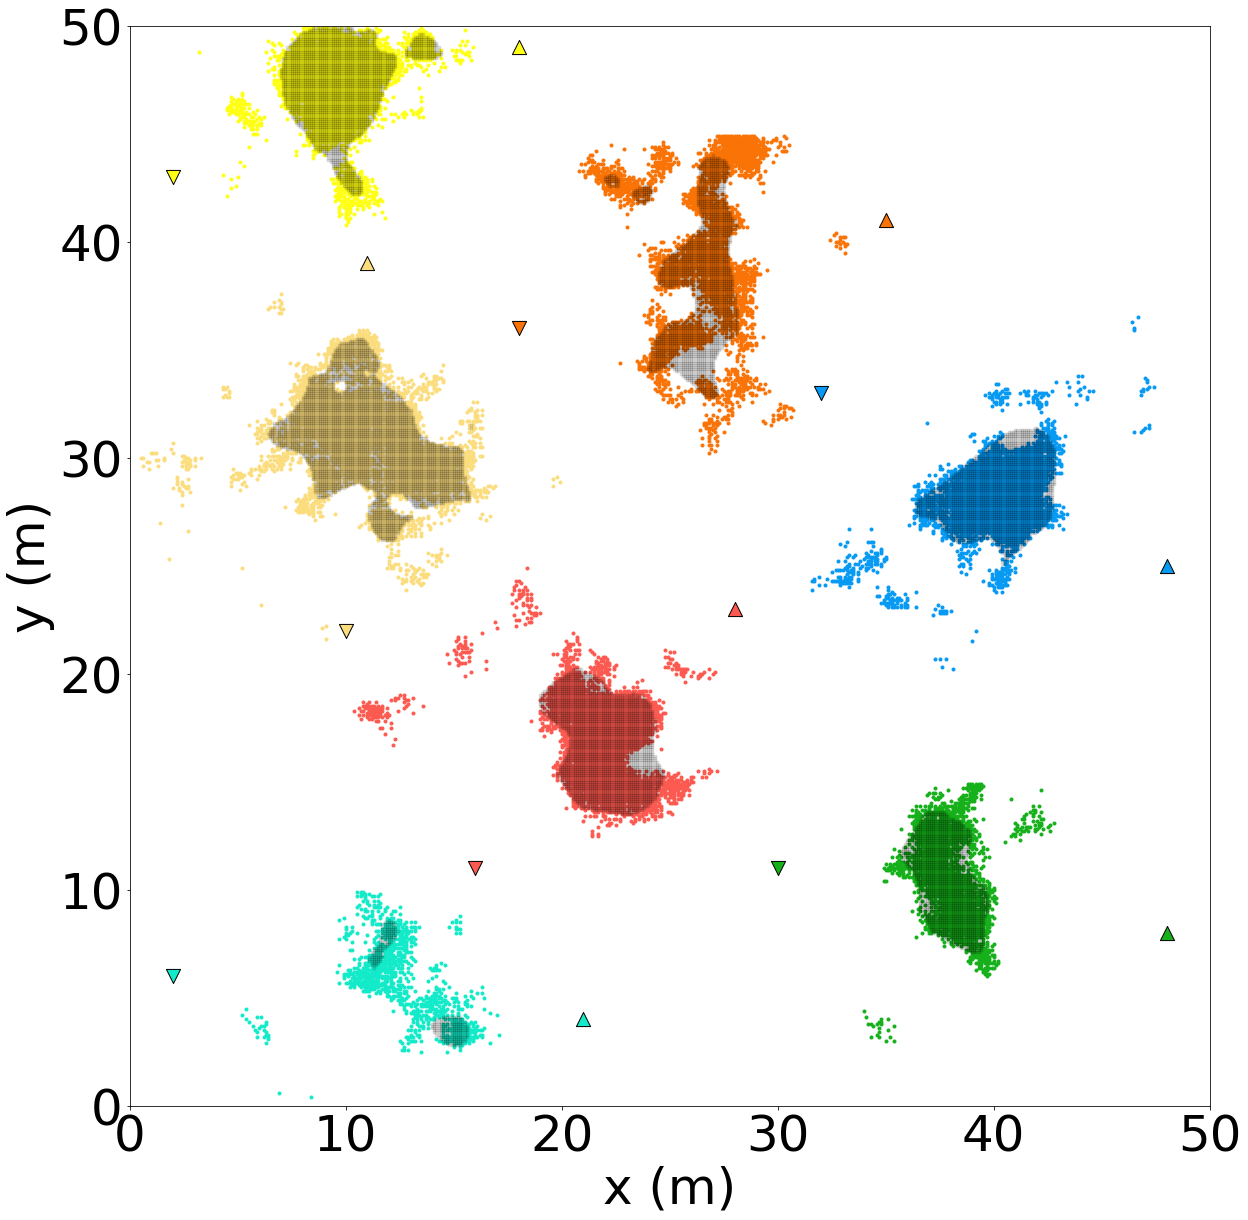

In [6]:
reload(sim)
sim.plotCFwithOverlay(n, tjcps, pjcps, qBase, region)
plt.gca().invert_yaxis()
plt.show()

In [17]:
#setup the delay-tolerant relay system
reload(dtr)
dt_sys = dtr.DTR(pcs, region, els, beta, th=GAMMA_TH, p_th = p_th)

Extracted edges...
Polygons constructed, looking for holes...
Constructed 2 possibly non-convex polygons
5 total subregions
Extracted edges...
Polygons constructed, looking for holes...
Constructed 1 possibly non-convex polygons
8 total subregions
Extracted edges...
No Improvement, orphaned edges exist
PolyConstructor: ([13.2 27.7])  ([13.3 27.7])  ([13.4 27.7])  ([13.5 27.7])  ([13.6 27.7])  ([13.7 27.7])  ([13.9 27.8])  ([14.  27.8])  ([14.1 27.8])  ([14.3 27.9])  ([14.4 27.9])  ([14.5 27.9])  ([14.7 28. ])  ([14.8 28. ])  ([14.9 28. ])  ([15.1 28.1])  ([15.2 28.1])  ([15.3 28.1])  ([15.4 28.1])  ([15.6 28. ])  ([15.7 28.1])  ([15.7 28.2])  ([15.7 28.3])  ([15.7 28.4])  ([15.6 28.6])  ([15.6 28.7])  ([15.5 28.9])  ([15.5 29. ])  ([15.5 29.1])  ([15.4 29.3])  ([15.4 29.4])  ([15.4 29.5])  ([15.4 29.6])  ([15.4 29.7])  ([15.4 29.8])  ([15.4 29.9])  ([15.4 30. ])  ([15.4 30.1])  ([15.4 30.2])  ([15.4 30.3])  ([15.3 30.4])  ([15.2 30.5])  ([15.1 30.5])  ([15.  30.5])  ([14.9 30.5])  ([14

Total of 361 Permutations to Try
Working on Permutation (0, 1, 2, 6, 4, 5, 3)
Academic license - for non-commercial use only - expires 2022-07-30
Using license file /opt/gurobi912/gurobi.lic
Optimal Solution Improved to 106.47
Working on Permutation (0, 1, 2, 3, 4, 5, 6)
skiping based on lower bound
Working on Permutation (0, 1, 2, 3, 4, 6, 5)
skiping based on lower bound
Working on Permutation (0, 1, 2, 3, 5, 4, 6)
skiping based on lower bound
Working on Permutation (0, 1, 2, 3, 5, 6, 4)
skiping based on lower bound
Working on Permutation (0, 1, 2, 3, 6, 4, 5)
skiping based on lower bound
Working on Permutation (0, 1, 2, 3, 6, 5, 4)
skiping based on lower bound
Working on Permutation (0, 1, 2, 4, 3, 5, 6)
skiping based on lower bound
Working on Permutation (0, 1, 2, 4, 3, 6, 5)
skiping based on lower bound
Working on Permutation (0, 1, 2, 4, 5, 3, 6)
skiping based on lower bound
Working on Permutation (0, 1, 2, 4, 5, 6, 3)
skiping based on lower bound
Working on Permutation (0, 1, 2, 

Working on Permutation (0, 2, 6, 4, 3, 1, 5)
skiping based on lower bound
Working on Permutation (0, 2, 6, 4, 5, 1, 3)
Working on Permutation (0, 2, 6, 5, 1, 3, 4)
skiping based on lower bound
Working on Permutation (0, 2, 6, 5, 1, 4, 3)
skiping based on lower bound
Working on Permutation (0, 2, 6, 5, 3, 1, 4)
skiping based on lower bound
Working on Permutation (0, 2, 6, 5, 4, 1, 3)
skiping based on lower bound
Working on Permutation (0, 3, 1, 2, 4, 5, 6)
skiping based on lower bound
Working on Permutation (0, 3, 1, 2, 4, 6, 5)
skiping based on lower bound
Working on Permutation (0, 3, 1, 2, 5, 4, 6)
skiping based on lower bound
Working on Permutation (0, 3, 1, 2, 5, 6, 4)
skiping based on lower bound
Working on Permutation (0, 3, 1, 2, 6, 4, 5)
Working on Permutation (0, 3, 1, 2, 6, 5, 4)
skiping based on lower bound
Working on Permutation (0, 3, 1, 4, 2, 5, 6)
skiping based on lower bound
Working on Permutation (0, 3, 1, 4, 2, 6, 5)
skiping based on lower bound
Working on Permutation

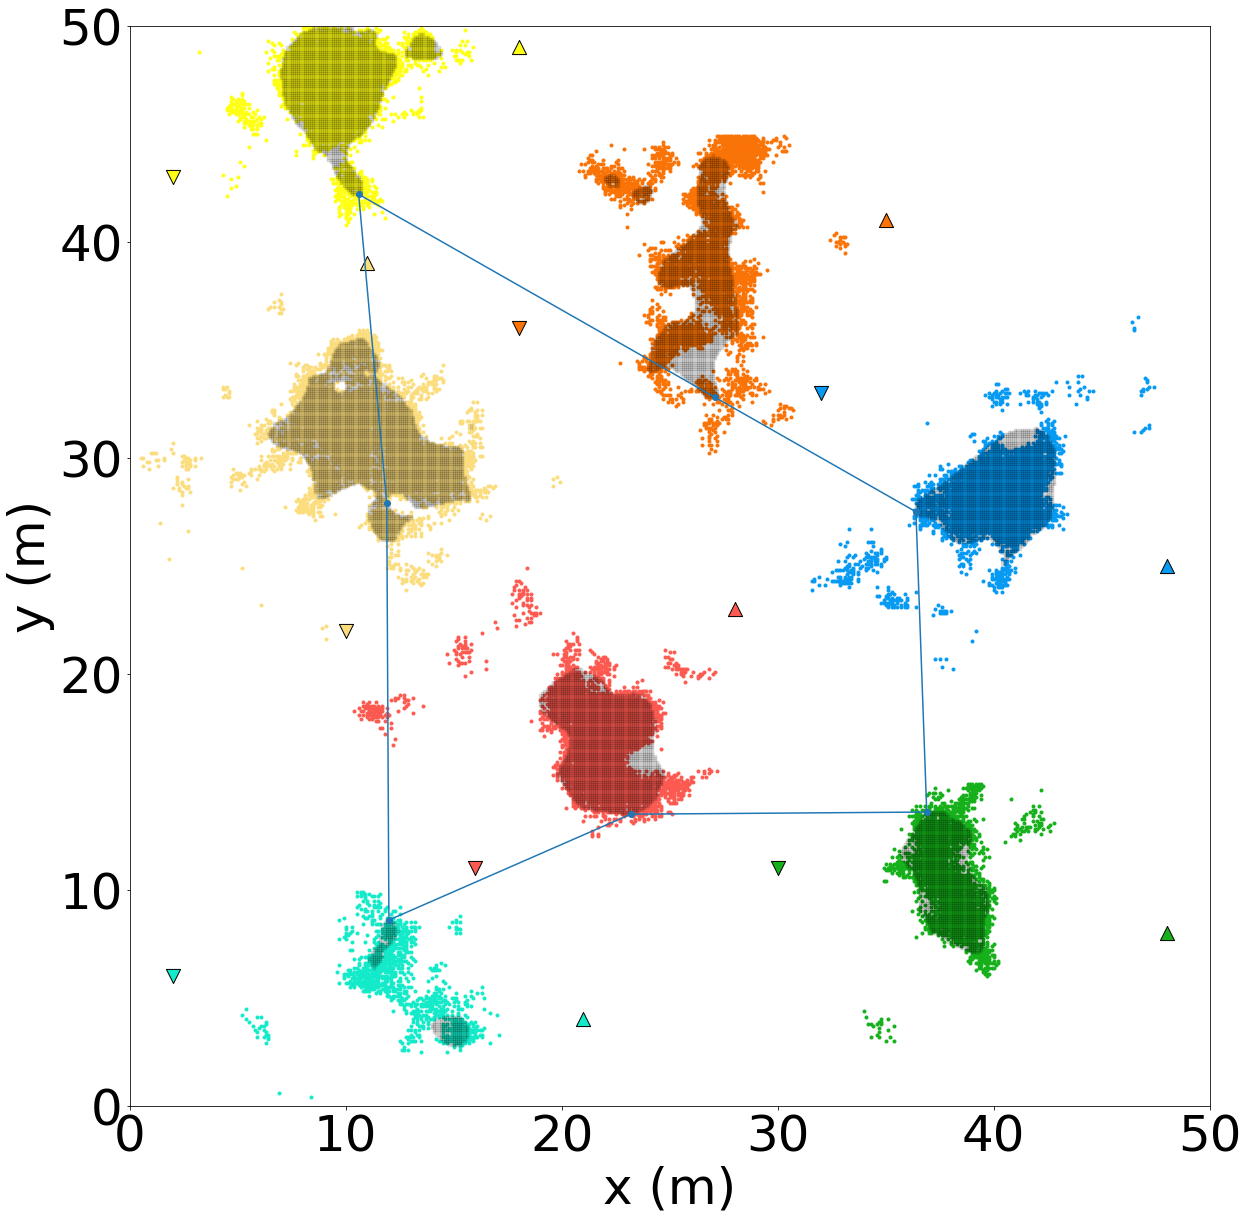

(0, 1, 3, 5, 4, 6, 2)

In [8]:
#Calculate baseline TSPN policy
# import gurobi_solvers as GB
# reload(GB)
reload(TSPN)
regions = dt_sys.cregions
tspn_min, tspn_argmin = TSPN.TSPN_BF(regions, (0, 1, 2, 6, 4, 5, 3))
x=tspn_argmin[0]

reload(sim)
order = list(tspn_argmin[1])
order.append(0)#complete the loop
sim.plotCFwithOverlay(n, tjcps, pjcps, qBase, region)
plt.plot(x[order,0], x[order,1], zorder=100)
plt.scatter(x[:,0], x[:,1], zorder = 100)
plt.gca().invert_yaxis()
plt.show()

tspn_argmin[1]

In [28]:
reload(dtr)
reload(sim)

v = 100
AORP = sim.calc_AORP(dt_sys, v)

    model.name="unknown";
      - termination condition: optimal
      - message from solver: SHOT\x3a Solved to local optimality
Optimized Waiting Time: 1.1661
    model.name="unknown";
      - termination condition: optimal
      - message from solver: SHOT\x3a Solved to local optimality
Optimized Waiting Time: 1.0135
    model.name="unknown";
      - termination condition: optimal
      - message from solver: SHOT\x3a Solved to local optimality
Optimized Waiting Time: 0.9997
    model.name="unknown";
      - termination condition: optimal
      - message from solver: SHOT\x3a Solved to local optimality
Optimized Waiting Time: 1.2687
    model.name="unknown";
      - termination condition: optimal
      - message from solver: SHOT\x3a Solved to local optimality
Optimized Waiting Time: 1.0185
    model.name="unknown";
      - termination condition: optimal
      - message from solver: SHOT\x3a Solved to local optimality
Optimized Waiting Time: 1.1492
    model.name="unknown";
      - 

In [25]:
# reload(SHOT)
# pi = AORP['pi']
# x = AORP['X']
# S = np.zeros((n,n))
# for i in range(n):
#     for j in range(n):
#         S[i,j] = np.linalg.norm(x[i] - x[j])

# print(pi)
# print(S)
# P, val = SHOT.min_PWD_over_P(pi, S, verbose = False)


In [29]:
%%notify
reload(sim)
TSPNP={'X':x, 'SEQ':tspn_argmin[1]}
hrs = 1
mins = 0
seconds = 0

print('Velocity = %f'%(v))

motion_power = motion.LinearMotionPower(7.2, 0.29, v)
sim.run_sims(dt_sys.ps, AORP, TSPNP, hrs, mins, seconds, motion_power, MOBILE_TX_POWER.W, v)
print('done')

Velocity = 100.000000
Theotretical MB serviced: 19584.000000000004
Theoretical Energy Consumption (J): 1711531.4399999997
	Th. WT	WT	E (J)	MBS	MBR
AORP	1.00	1.02	1712734.04	19558.70	4.85
Tab	---	0.74	1712820.74	19556.50	3.65
TSPN	---	0.73	1712820.71	19556.45	3.35
done


<IPython.core.display.Javascript object>

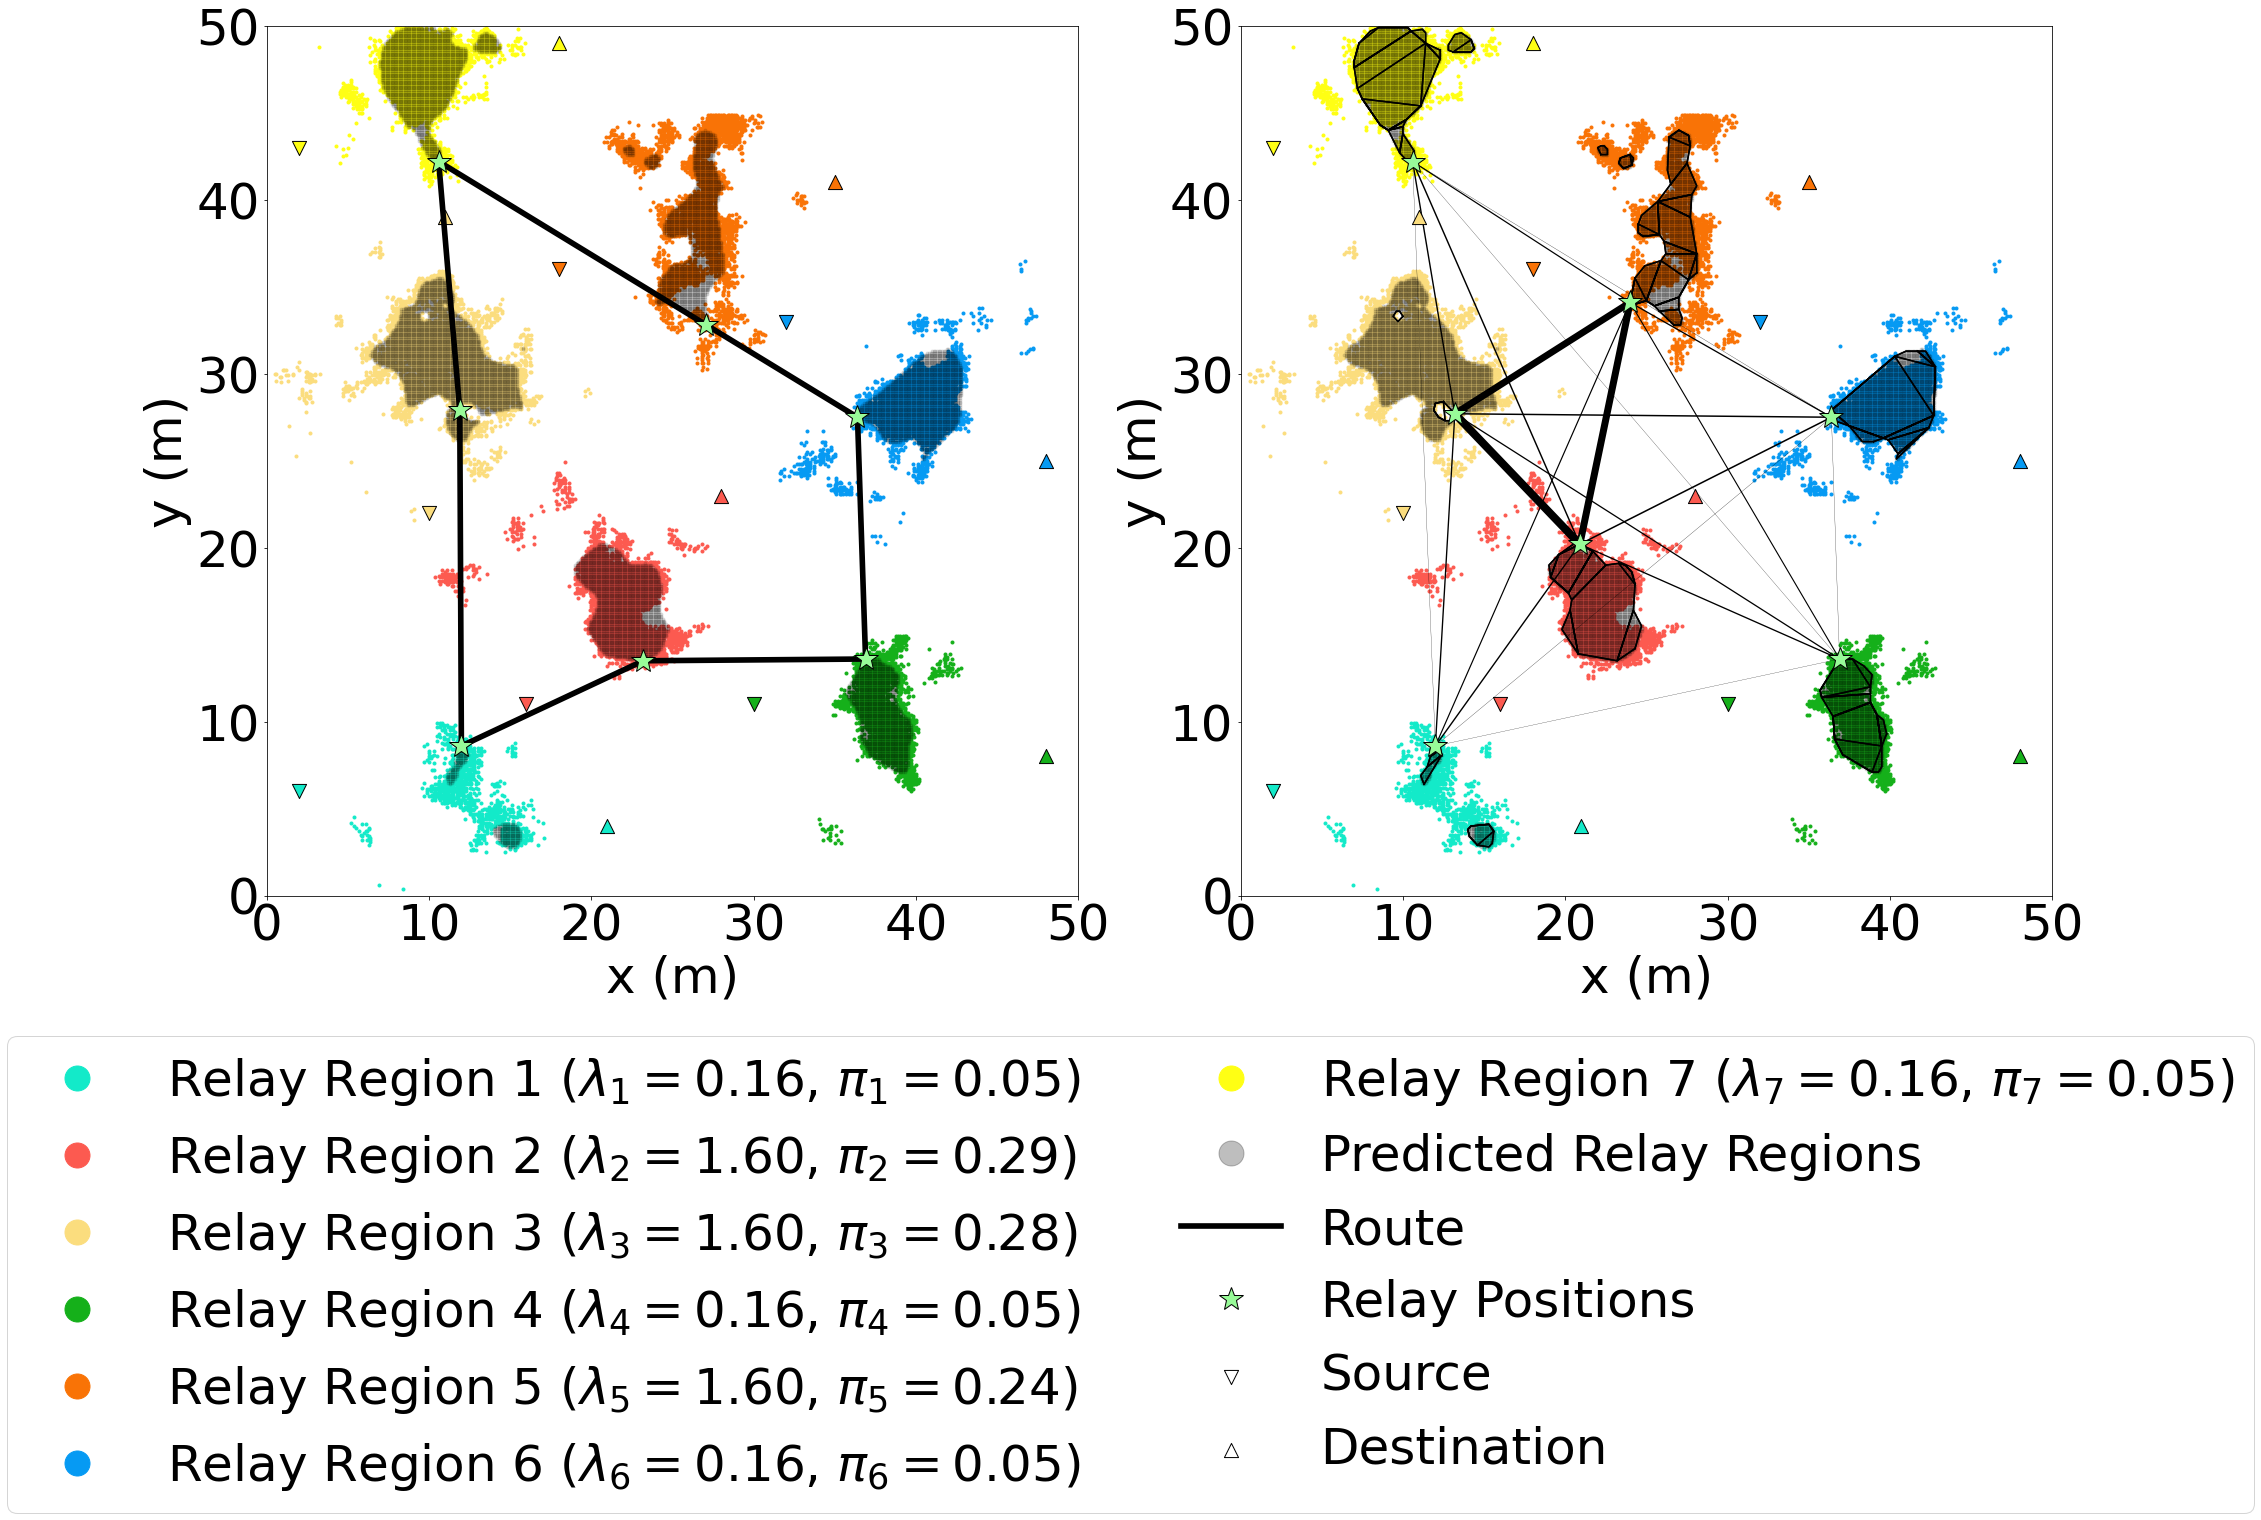

In [30]:
reload(sim)
sim.plot_AORP_W_TSPN(dt_sys, AORP, TSPNP, tjcps, pjcps, qBase, region, els, AORP['pi'])
sim.save_plt('eight_outlier_TSPNP_W_AORP.png')